In [1]:
import sys

In [2]:
sys.path.insert(0, '/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data')

In [3]:
sys.path

['/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data',
 '',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python36.zip',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/lib-dynload',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/site-packages',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/site-packages/IPython/extensions',
 '/home/joe2/.ipython']

In [4]:
sys.path.remove('')

In [5]:
from fin_data import DailyTimeSeries
from fracdiff import FractionalDifferentiation as fd

import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Using TensorFlow backend.


In [18]:
# Choose Company:
symbol = 'AAPL'

# Ininialize class
dts = DailyTimeSeries(symbol)

In [35]:
# Ininiate Dataframe

df = dts.initiate()
df.head()

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-10 14:27:28 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
1999-09-10,76.0000,77.688,74.688,77.438,2.4136,114690800.0,0.0
1999-09-13,77.0630,77.063,74.813,75.000,2.3376,63000000.0,0.0
1999-09-14,74.7190,78.500,74.688,77.813,2.4253,97073200.0,0.0
1999-09-15,78.8642,79.125,75.250,75.375,2.3493,89894000.0,0.0
1999-09-16,76.0630,78.063,73.875,76.813,2.3941,110471200.0,0.0


In [37]:
funs = ['totalrevenue',  'totalcostofrevenue', 'totalgrossprofit', 'totalpretaxincome', 'weightedavebasicdilutedsharesos', 'cashdividendspershare']
techs = ['SMA', 'WMA', 'STOCH', 'ROC', 'AROON']
macros = ['housing_index', 'confidence_index', 'trade_index', 'longterm_rates', 'shortterm_rates']

In [38]:
df = dts.add_fundamentals(df, funs)
df = dts.add_technicals(techs, df)
df = dts.add_macro(df, macros)

################################################################### 
 Ticker:  AAPL 
 Fundamentals Retrieved:  ['AAPL_open' 'AAPL_high' 'AAPL_low' 'AAPL_close' 'AAPL_adjusted_close'
 'AAPL_volume' 'AAPL_dividend_amount' 'AAPL_totalrevenue'
 'AAPL_totalcostofrevenue' 'AAPL_totalgrossprofit'
 'AAPL_totalpretaxincome' 'AAPL_weightedavebasicdilutedsharesos'
 'AAPL_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  AAPL 
 Retrieved Data Start Date:  2009-07-22 
 Retrieved Data End Date:  2019-07-31 
 Data Retrieved:  ['AAPL_totalrevenue', 'AAPL_totalcostofrevenue', 'AAPL_totalgrossprofit', 'AAPL_totalpretaxincome', 'AAPL_weightedavebasicdilutedsharesos', 'AAPL_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  Simple Moving Ave

/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################


/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


In [39]:
todrop = []
for col in df.columns:
    if df[col].isnull().sum()/len(df) >  .1:
        todrop.append(col)

df = df.drop(labels=todrop, axis=1)
df = df.dropna(axis=0)

In [40]:
df.shape

(4299, 32)

In [41]:
df['target'] = fd.frac_diff_ffd(df[['AAPL_adjusted_close']], .35).shift(-1)['AAPL_adjusted_close']
#                          df['AAPL_adjusted_close']) / 
#                         (df['AAPL_adjusted_close']))*100


df['target']

df = df.dropna()

In [42]:
df.isnull().sum()

AAPL_open                               0
AAPL_high                               0
AAPL_low                                0
AAPL_close                              0
AAPL_adjusted_close                     0
AAPL_volume                             0
AAPL_dividend_amount                    0
AAPL_totalrevenue                       0
AAPL_totalcostofrevenue                 0
AAPL_totalgrossprofit                   0
AAPL_totalpretaxincome                  0
AAPL_weightedavebasicdilutedsharesos    0
AAPL_cashdividendspershare              0
AAPL_SMA                                0
AAPL_WMA                                0
AAPL_SlowK                              0
AAPL_SlowD                              0
AAPL_ROC                                0
AAPL_Aroon Up                           0
AAPL_Aroon Down                         0
housing_index                           0
conf_index                              0
conf_index_SE                           0
trade_value                       

In [43]:
X = df.drop(columns='target')
y = df[['target']].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    shuffle=False)

In [45]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [46]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [71]:
train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=30,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=20)

In [72]:
test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=30, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=20)

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [66]:
from keras import optimizers

In [73]:
model = Sequential()
model.add(LSTM(361, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(196, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(81, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(1))

sgd = optimizers.SGD(lr=.015, momentum=0.01, decay=0.0001)


model.compile(optimizer=sgd, loss='mean_squared_logarithmic_error')

checkpointer = ModelCheckpoint(filepath='weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5',
                               verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpointer]


history_2 = model.fit_generator(train_data_generator, 
                                  epochs = 50,
                                  validation_data=test_data_generator,
                                  workers=-1,
                                  use_multiprocessing=True,
                                  verbose=1,
                                  callbacks=callbacks_list)

Epoch 1/50
98/98 [==============================] - 103s 1s/step - loss: 0.2235 - val_loss: 0.4933

Epoch 00001: val_loss improved from inf to 0.49331, saving model to weights-improvement-01-0.49.hdf5
Epoch 2/50
98/98 [==============================] - 92s 934ms/step - loss: 0.2253 - val_loss: 0.5874

Epoch 00002: val_loss did not improve from 0.49331
Epoch 3/50
98/98 [==============================] - 91s 931ms/step - loss: 0.2365 - val_loss: 0.6174

Epoch 00003: val_loss did not improve from 0.49331
Epoch 4/50
98/98 [==============================] - 92s 937ms/step - loss: 0.2426 - val_loss: 0.6245

Epoch 00004: val_loss did not improve from 0.49331
Epoch 5/50
98/98 [==============================] - 92s 936ms/step - loss: 0.2479 - val_loss: 0.6366

Epoch 00005: val_loss did not improve from 0.49331
Epoch 6/50
98/98 [==============================] - 91s 930ms/step - loss: 0.2515 - val_loss: 0.6418

Epoch 00006: val_loss did not improve from 0.49331
Epoch 7/50
98/98 [================

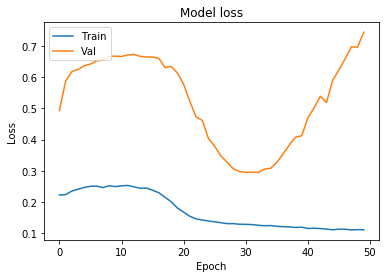

In [76]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(20,12))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(0,100)
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [ ]:
#keep2
model = Sequential()
model.add(LSTM(128, activation='sigmoid', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
#keep3
model = Sequential()
model.add(LSTM(256, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(144, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(72, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
#keep4

model = Sequential()
model.add(LSTM(361, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(196, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(81, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))

Below is model for pca and feature importance testing.
Shapley values and other variables will be pickled for later retrieval.
Run model initialization and compile. Load weights

In [162]:
#weights-improvement-33-0.29.hdf5
#for feature importance / shapley values, pca_concurrance

model = Sequential()
model.add(LSTM(361, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(196, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(81, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(1))

sgd = optimizers.SGD(lr=.015, momentum=0.01, decay=0.0001)


model.compile(optimizer=sgd, loss='mean_squared_logarithmic_error')

In [167]:
# Pickle the compiled model.
# This allows compatible weights to be loaded directly

with open('model-33-0.29.pickle', 'wb') as mod_f:
    pickle.dump(model, mod_f)

In [168]:
with open('model-33-0.29.pickle', 'rb') as mod_fr:
    model = pickle.load(mod_fr)

In [169]:
model.load_weights('weights-improvement-33-0.29.hdf5')

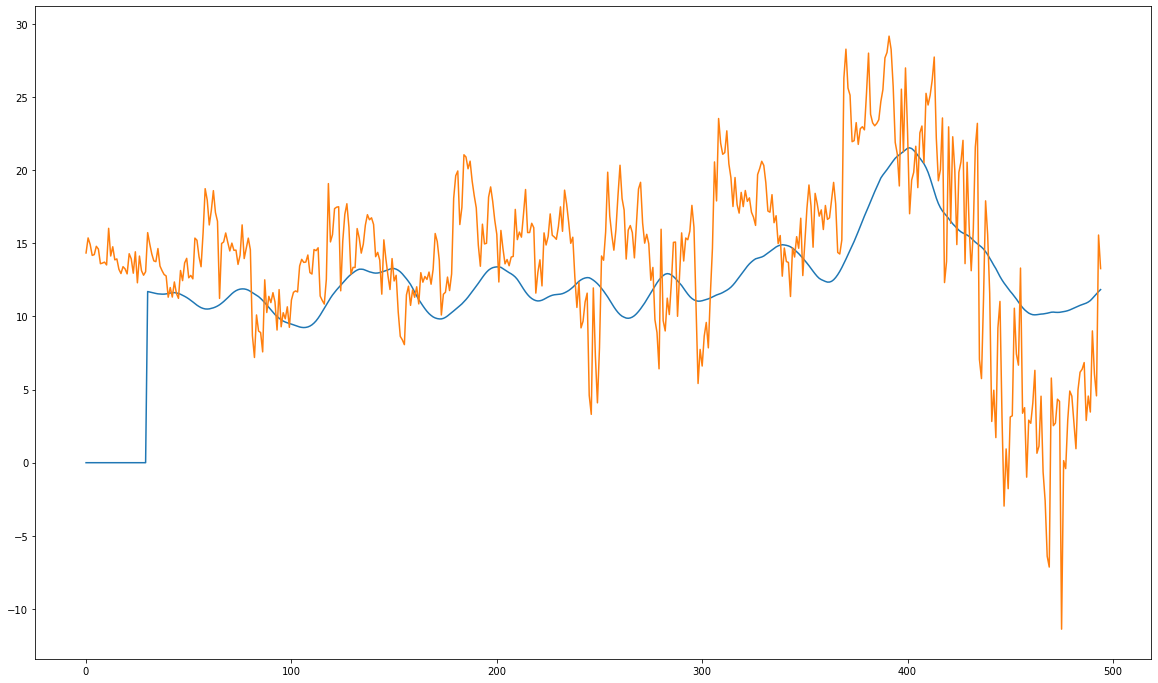

In [170]:

model.compile(optimizer=sgd, loss='mean_squared_logarithmic_error')

y_pred = model.predict_generator(test_data_generator)

plt.figure(figsize=(20,12))
for i in range(30):
    y_pred = np.insert(y_pred, 0,[0], axis=0)
plt.plot(y_pred)
plt.plot(y_test);

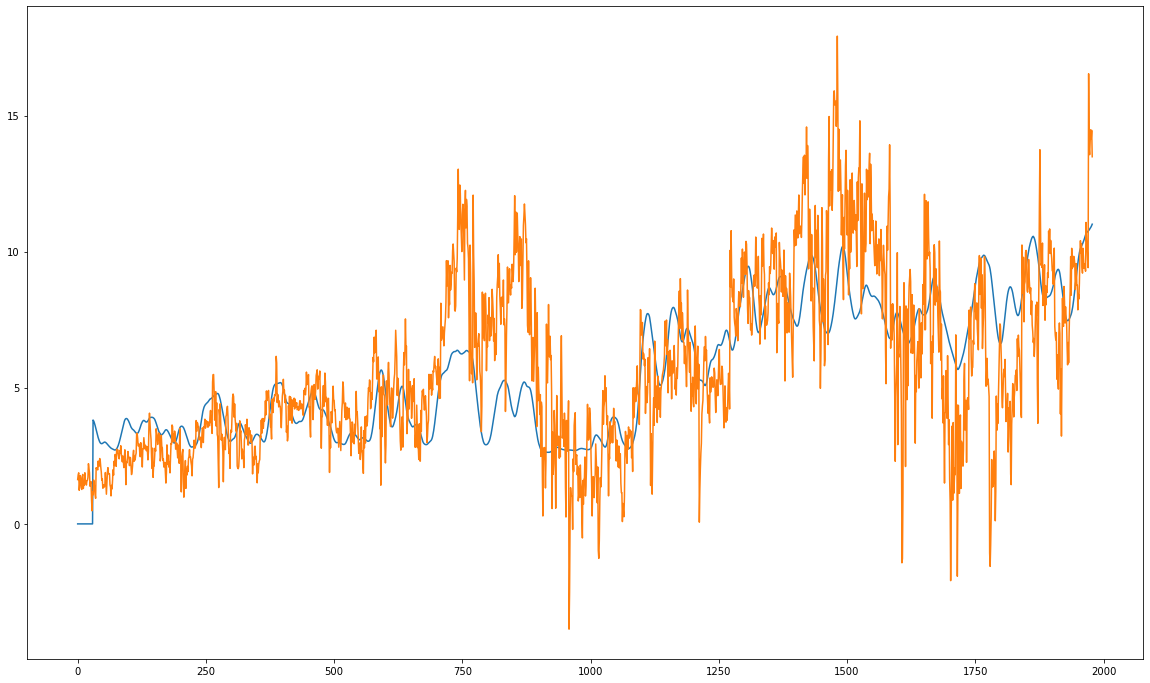

In [171]:
# Run after loading weights and compiling above.

# Re-compiling should not be necessary
#model.compile(optimizer=sgd, loss='mean_squared_logarithmic_error')

y_pred = model.predict_generator(train_data_generator)

plt.figure(figsize=(20,12))
for i in range(30):
    y_pred = np.insert(y_pred, 0,[0], axis=0)
plt.plot(y_pred)
plt.plot(y_train);

# Feature importance #

**Extract (from generator) and flatten functions:**

* written by Alex Witt

In [ ]:
# For reloading after kernel restart.
# Re-run function definitions, then skip to summary plots or
# shap dataframe initialization

shaps_vals = np.load('shaps_vals_features.npy')
a = np.load('feature_gen_extracted.npy')
b = np.load('target_gen_extracted.npy')

In [157]:
def extract_data(generator):
    for i in np.arange(len(generator)):
        if i == 0:
            a, b = generator[i]
        else: 
            c, d = generator[i]

            a = np.vstack((a, c))
            b = np.vstack((b, d))
            
    return a, b

In [116]:
def individual_array(sample):
    
    # get the means for each sampling
    for i in np.arange(len(sample[0])):
        means = []
        for j in np.arange(len (sample)):
            means.append(sample[j][i])
        s_value = np.array(np.mean(means))

        if i == 0:
            final_array = s_value
        else:
            final_array = np.hstack((final_array, s_value))
            
    return final_array

In [118]:
def flatten_shap_values(shap_vals):
    
    #Pull the array out of the list. 
    sv = shap_vals[0]
    
    count = 0
    for sample in sv: 
        sample_array = individual_array(sample)
        if count == 0:
            final_array = sample_array
        else:
            final_array = np.vstack((final_array, sample_array))
        
        count +=1
        
    return final_array

In [93]:
a, b = extract_data(test_data_generator)

In [94]:
a.shape

(465, 30, 32)

In [95]:
b.shape

(465, 1)

In [99]:
from shap import DeepExplainer, summary_plot

In [104]:
de = DeepExplainer(model = model, data=a)

In [105]:
shaps_vals = de.shap_values(a)

In [114]:
print(shaps_vals[0].shape) 
print(shaps_vals[0][0].shape)
print(shaps_vals[0][0][0].shape)

(465, 30, 32)
(30, 32)
(32,)


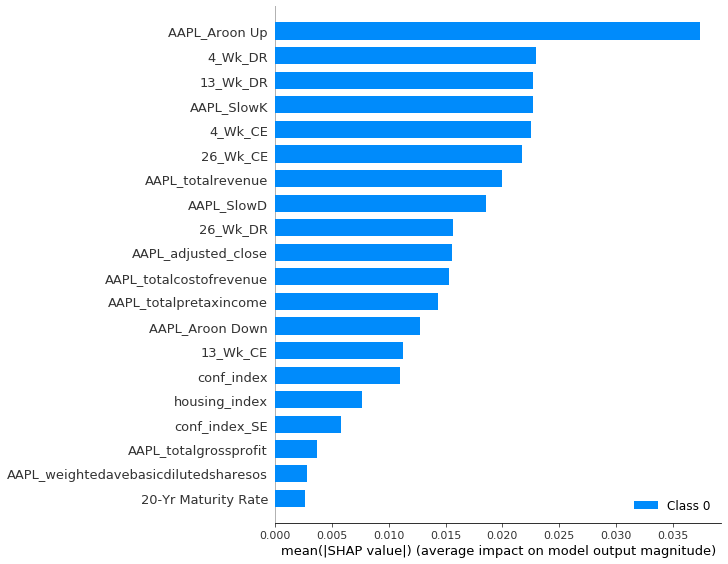

In [115]:
summary_plot([shaps_vals[0][100]], feature_names=df.columns)

In [117]:
individual_array(shaps_vals[0][0])

array([-1.95372890e-04,  5.03887572e-04,  2.59399063e-04,  2.42542914e-04,
       -2.14617537e-02,  6.91222367e-04,  2.18830178e-04, -1.23070169e-02,
       -1.01962387e-02,  2.43141285e-03,  7.21550633e-03,  9.85387931e-03,
       -2.48213073e-03, -2.36625349e-04, -1.37103326e-03,  2.01211088e-02,
        1.81687679e-02,  4.86611081e-04,  2.72591937e-02,  1.65685742e-02,
       -1.66894188e-02,  1.94336898e-03, -1.11318485e-03,  2.50019449e-03,
       -6.02540613e-05,  3.58121293e-04, -4.03147627e-02, -3.60263531e-02,
       -3.63639528e-02, -1.49695570e-02,  2.45353997e-02,  2.86111731e-02])

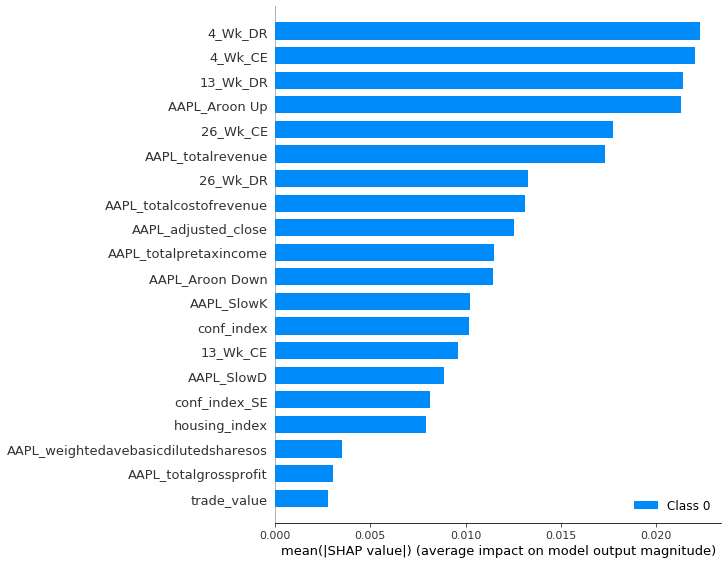

In [131]:
summary_plot([flatten_shap_values(shaps_vals)], 
             feature_names=(df.drop(columns=['target'])
                            .columns
                            .tolist()))

In [132]:
shap_df = pd.DataFrame(data=flatten_shap_values(shaps_vals),columns = df.drop(columns='target').columns.tolist())

In [158]:
shap_df.head()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount,AAPL_totalrevenue,AAPL_totalcostofrevenue,AAPL_totalgrossprofit,AAPL_totalpretaxincome,AAPL_weightedavebasicdilutedsharesos,AAPL_cashdividendspershare,AAPL_SMA,AAPL_WMA,AAPL_SlowK,AAPL_SlowD,AAPL_ROC,AAPL_Aroon Up,AAPL_Aroon Down,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,4_Wk_DR,4_Wk_CE,13_Wk_DR,13_Wk_CE,26_Wk_DR,26_Wk_CE
0,-0.000195,0.000504,0.000259,0.000243,-0.021462,0.000691,0.000219,-0.012307,-0.010196,0.002431,0.007216,0.009854,-0.002482,-0.000237,-0.001371,0.020121,0.018169,0.000487,0.027259,0.016569,-0.016689,0.001943,-0.001113,0.002500,-0.000060,0.000358,-0.040315,-0.036026,-0.036364,-0.014970,0.024535,0.028611
1,-0.000197,0.000496,0.000262,0.000241,-0.021291,0.000682,0.000220,-0.012294,-0.010183,0.002424,0.007195,0.009833,-0.002480,-0.000232,-0.001349,0.018850,0.017106,0.000447,0.026835,0.016520,-0.016634,0.002053,-0.000761,0.002501,-0.000099,0.000314,-0.039678,-0.035570,-0.035896,-0.014794,0.024216,0.028331
2,-0.000198,0.000489,0.000265,0.000240,-0.021140,0.000673,0.000221,-0.012284,-0.010171,0.002417,0.007173,0.009814,-0.002478,-0.000227,-0.001329,0.017552,0.016018,0.000409,0.026506,0.016490,-0.016582,0.002156,-0.000428,0.002499,-0.000125,0.000287,-0.039002,-0.035078,-0.035451,-0.014658,0.023879,0.028051
3,-0.000199,0.000482,0.000267,0.000238,-0.020999,0.000671,0.000222,-0.012271,-0.010162,0.002410,0.007151,0.009796,-0.002475,-0.000223,-0.001311,0.016223,0.014905,0.000372,0.026280,0.016411,-0.016533,0.002252,-0.000120,0.002491,-0.000137,0.000277,-0.038355,-0.034563,-0.035027,-0.014530,0.023551,0.027786
4,-0.000202,0.000475,0.000270,0.000237,-0.020857,0.000668,0.000224,-0.012260,-0.010152,0.002406,0.007128,0.009779,-0.002473,-0.000218,-0.001293,0.014910,0.013783,0.000339,0.026158,0.016319,-0.016486,0.002339,0.000166,0.002473,-0.000135,0.000282,-0.037770,-0.034071,-0.034608,-0.014401,0.023223,0.027562


In [150]:
np.save('shaps_vals', shaps_vals)
np.save('feature_gen_extracted', a)
np.save('target_gen_extracted', b)

In [133]:
import pca_concordance as pcac

In [149]:
pcac.feature_pca_concordance(a, shap_df)

NameError: name '_standardize_df' is not defined

In [135]:
import dill

In [144]:
shaps_vals[0]

array([[[-3.65744481e-04,  2.29815593e-04,  1.49163116e-04, ...,
          6.38209003e-03,  2.03730171e-02,  1.12902092e-02],
        [-4.41540793e-04,  3.47093442e-04,  1.43310205e-04, ...,
          4.15099481e-03,  2.17322931e-02,  1.29816578e-02],
        [-4.38043103e-04,  4.43573992e-04,  1.92390844e-04, ...,
          2.08010137e-03,  2.33950994e-02,  1.52901652e-02],
        ...,
        [-3.34703865e-05, -1.16755800e-04, -4.46514317e-05, ...,
         -7.38935171e-03, -7.54106864e-04,  7.74812988e-03],
        [-1.73002513e-05, -8.43553651e-05, -3.67600490e-05, ...,
         -3.73506440e-03, -1.30850251e-03,  4.12026767e-03],
        [-7.15988261e-06, -3.97627651e-05, -2.12283842e-05, ...,
         -8.87824648e-04, -1.04768177e-03,  1.34277014e-03]],

       [[-3.65342631e-04,  2.23342037e-04,  1.40553392e-04, ...,
          6.20369017e-03,  2.05534255e-02,  1.13550966e-02],
        [-4.32123468e-04,  3.36037850e-04,  1.47853434e-04, ...,
          3.95846567e-03,  2.11310507e

In [148]:
a.shape, shaps_vals[0].shape

((465, 30, 32), (465, 30, 32))

In [146]:
len(shaps_vals)

1

True
True
True
